In [116]:
!pip install wordcloud

In [ ]:
!gdown 1AIlehlyZ7rTsk0edgfnbTEXzfahrZl0N

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string

import nltk
nltk.download('punkt') #tokenization
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import joblib
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [118]:
df = pd.read_csv('/content/movie.csv')
df.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [120]:
# shuffle
df = df.sample(frac=0.1,random_state=1)
df.to_csv('movie_sample.csv')
df.head()

,text,label
3841,I was reviewing some old VHS tapes I have and ...,1
12898,I never really knew who Robert Wuhl was before...,1
15032,This movie grabbed me with the incredible open...,1
36781,"Lame, cliched superhero action movie drivel. I...",0
9201,Little did I know that when I signed up the th...,0


In [121]:
df['label'].unique()

array([1, 0])

# Preprocess

In [122]:
stop = stopwords.words('english')
# the a an

In [123]:
#preprocess
df['text'] = df['text'].str.lower() # viết hoa thành viết thường
df['text'] = df['text'].str.replace(r'[^\w\s]', '', regex=True) # bỏ dấu câu
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df['text'] = df['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()])) #went => go

# EDA

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 3841 to 17248
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4000 non-null   object
 1   label   4000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 93.8+ KB


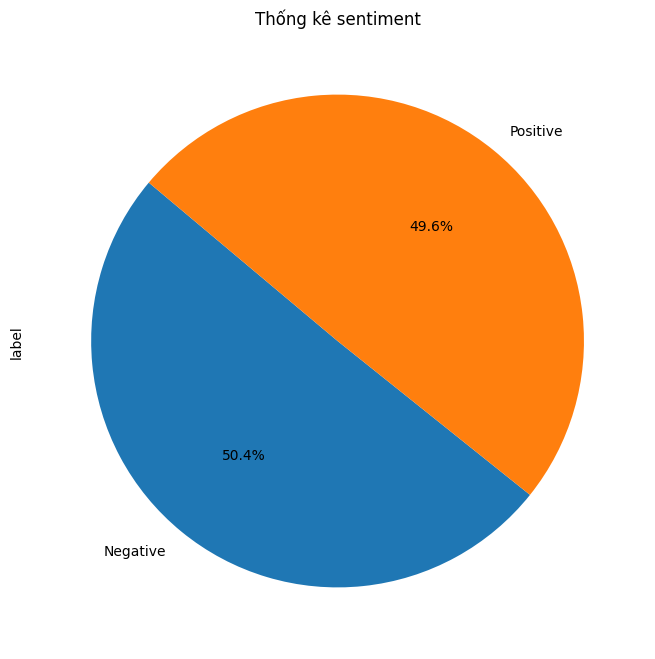

In [125]:
plt.figure(figsize=(8, 8))
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=140, labels=['Negative', 'Positive'])
plt.title('Thống kê sentiment')
plt.show()

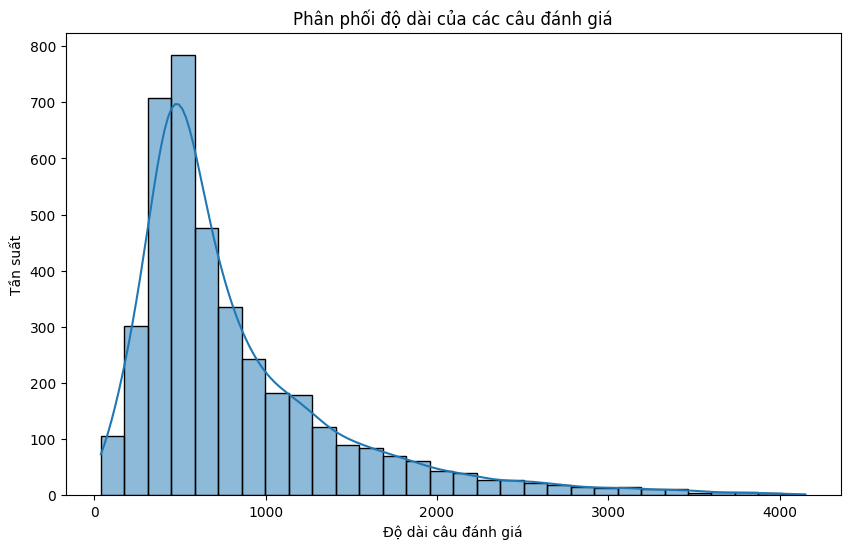

In [126]:
df['text_length'] = df['text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=30, kde=True)
plt.title('Phân phối độ dài của các câu đánh giá')
plt.xlabel('Độ dài câu đánh giá')
plt.ylabel('Tần suất')
plt.show()

In [127]:
def tokenize(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    return tokens


df['tokens'] = df['text'].apply(tokenize)
all_words = [word for tokens in df['tokens'] for word in tokens]
word_freq = pd.Series(all_words).value_counts()
word_freq = word_freq[1:20]

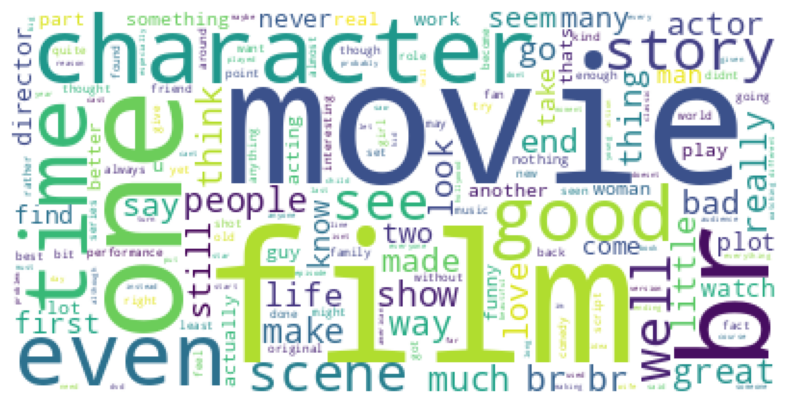

In [128]:
text = " ".join(review for review in df.text)

wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

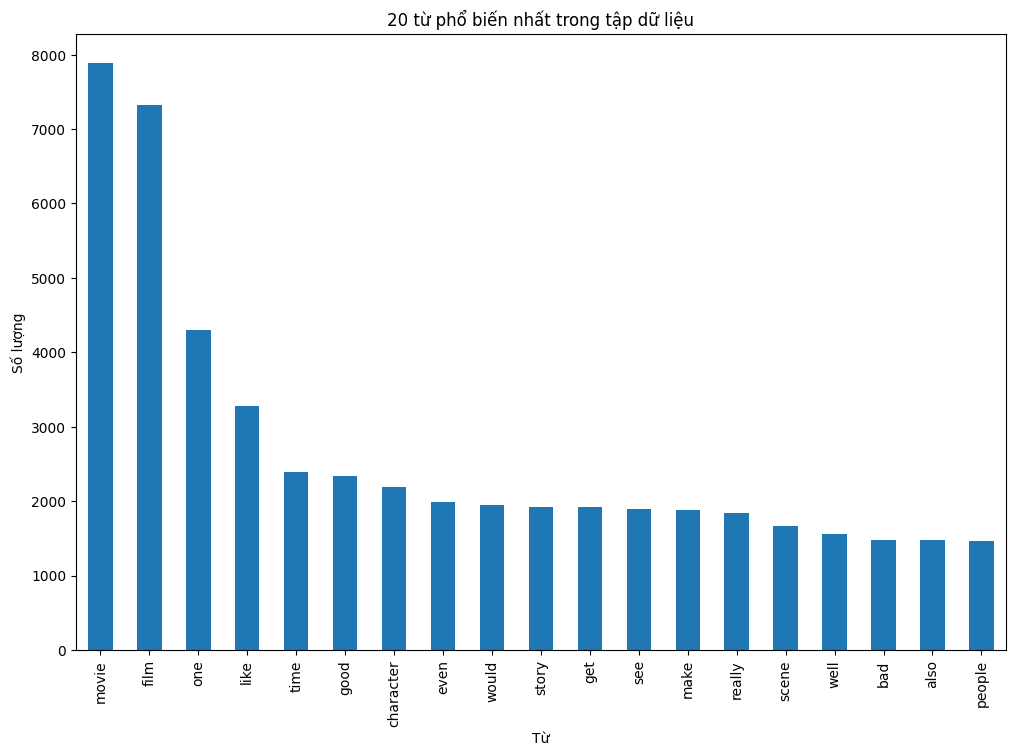

In [129]:
plt.figure(figsize=(12, 8))
word_freq.plot(kind='bar')
plt.title('20 từ phổ biến nhất trong tập dữ liệu')
plt.xlabel('Từ')
plt.ylabel('Số lượng')
plt.show()

# Mô hình máy học

## SVM

In [130]:
X = df['text']
y = df['label']

In [131]:
X

3841     reviewing old vhs tape came across tv show joh...
12898    never really knew robert wuhl seeing seeing re...
15032    movie grabbed incredible opening sequence tric...
36781    lame cliched superhero action movie drivel hig...
9201     little know signed pay channel package direct ...
                               ...                        
15218    possible journalist critic reminded u resembla...
24516    hilarious action comedy damian szifron take li...
16330    good thing film managed tie part one one worst...
23962    movie even big step form typical fare dished b...
17248    another long line flick made people think know...
Name: text, Length: 4000, dtype: object

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 8:2

tfidf= TfidfVectorizer(tokenizer=word_tokenize) # tokenize
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [133]:
svm_model = SVC(kernel='linear') # rbf
svm_model.fit(X_train, y_train)

SVC(kernel='linear')

In [134]:
predictions = svm_model.predict(X_test)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[310  75]
 [ 47 368]]
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       385
           1       0.83      0.89      0.86       415

    accuracy                           0.85       800
   macro avg       0.85      0.85      0.85       800
weighted avg       0.85      0.85      0.85       800



In [135]:
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)

print(f"Accuracy:  {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Accuracy:  0.85
F1 Score: 0.86
Precision: 0.83
Recall: 0.89


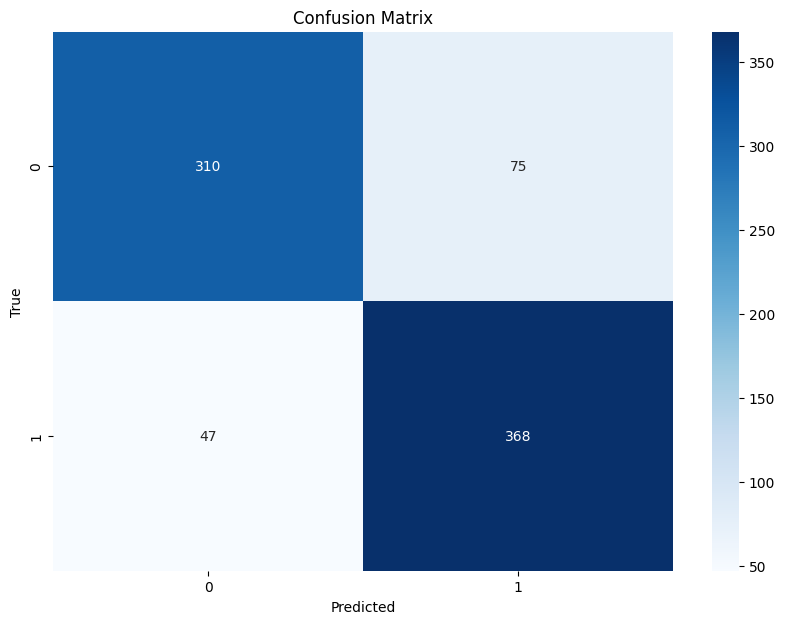

In [136]:
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [137]:
joblib.dump(svm_model, '/content/svm_model.pkl')
joblib.dump(tfidf, '/content/tfidf_vectorizer.pkl')

svm_model = joblib.load('/content/svm_model.pkl')
tfidf = joblib.load('/content/tfidf_vectorizer.pkl')

def svm_predict(user_input):
    processed_input = tfidf.transform([user_input])
    prediction = svm_model.predict(processed_input)
    return prediction[0]

user_input = input("Enter a movie review: ")
prediction = svm_predict(user_input)

if prediction == 0:
  prediction = "tiêu cực"
else:
  prediction = "tích cực"

print(f"Dự đoán: {prediction}")

Enter a movie review: This film is bad
Dự đoán: tiêu cực


## Random forest

In [138]:
# ensemble learning
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tfidf = TfidfVectorizer(tokenizer=word_tokenize)
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

random_forest_classifier = RandomForestClassifier(random_state=42)
random_forest_classifier.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


RandomForestClassifier(random_state=42)

In [139]:
predictions = random_forest_classifier.predict(X_test)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[324  61]
 [ 76 339]]
              precision    recall  f1-score   support

           0       0.81      0.84      0.83       385
           1       0.85      0.82      0.83       415

    accuracy                           0.83       800
   macro avg       0.83      0.83      0.83       800
weighted avg       0.83      0.83      0.83       800



In [140]:
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)

print(f"Accuracy:  {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Accuracy:  0.83
F1 Score: 0.83
Precision: 0.85
Recall: 0.82


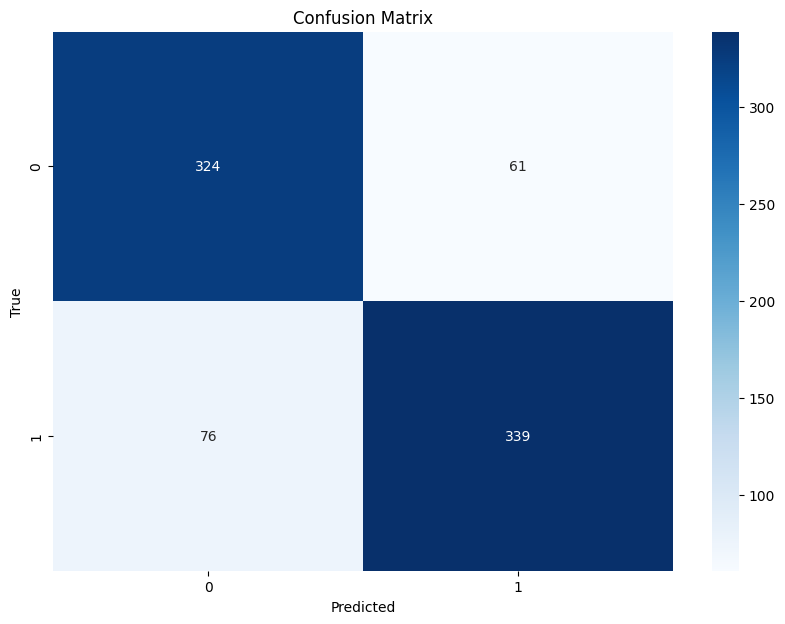

In [141]:
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [142]:
joblib.dump(random_forest_classifier, '/content/rf_model.pkl')
rf_model = joblib.load('/content/rf_model.pkl')
tfidf = joblib.load('/content/tfidf_vectorizer.pkl')

def rf_predict(user_input):
    processed_input = tfidf.transform([user_input])
    prediction = random_forest_classifier.predict(processed_input)
    return prediction[0]

user_input = input("Enter a movie review: ")
prediction = rf_predict(user_input)

if prediction == 0:
  prediction = "tiêu cực"
else:
  prediction = "tích cực"

print(f"Dự đoán: {prediction}")

Enter a movie review: This film is wonderful
Dự đoán: tích cực


## SGD Classifier

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


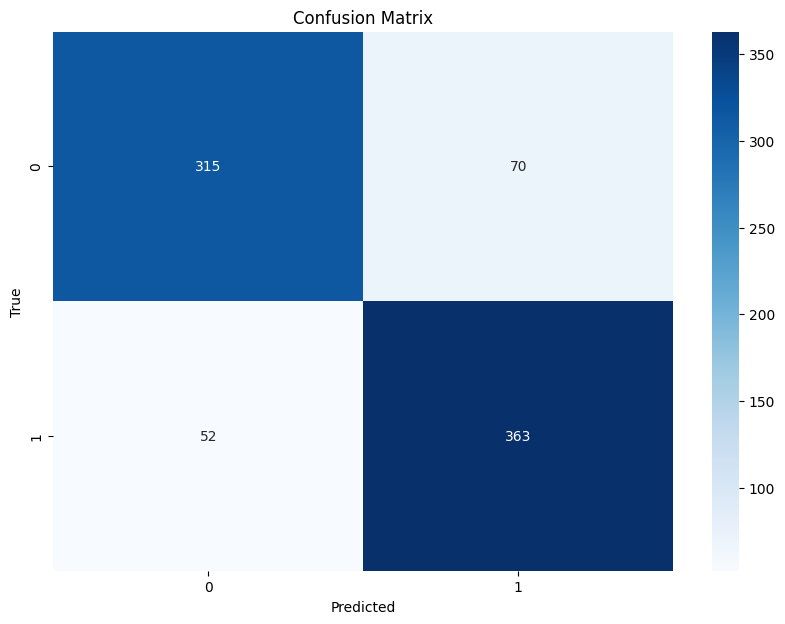

In [143]:
#maxent
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tfidf = TfidfVectorizer(tokenizer=word_tokenize)
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

sgd_model = SGDClassifier(loss='log_loss', random_state=1) #
sgd_model.fit(X_train, y_train)

predictions = sgd_model.predict(X_test)

cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [144]:
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Accuracy: 0.85
F1 Score: 0.86
Precision: 0.84
Recall: 0.87


In [145]:
joblib.dump(sgd_model, '/content/sgd_model.pkl')
sgd_model = joblib.load('/content/sgd_model.pkl')

def sgd_predict(user_input):
    processed_input = tfidf.transform([user_input])
    prediction = sgd_model.predict(processed_input)
    return prediction[0]

user_input = input("Enter a movie review: ")

prediction = sgd_predict(user_input)

if prediction == 0:
  prediction = "tiêu cực"
else:
  prediction = "tích cực"

print(f"Dự đoán: {prediction}")

Enter a movie review: I want to watch this film again
Dự đoán: tích cực


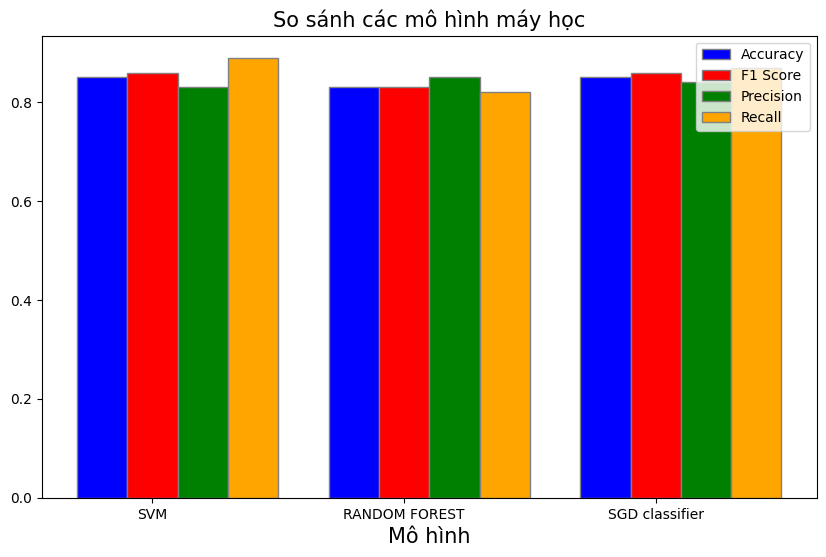

In [146]:
classifiers = ['SVM', 'RANDOM FOREST', 'SGD classifier']
accuracy = [0.85, 0.83, 0.85]
f1_score = [0.86, 0.83, 0.86]
precision = [0.83, 0.85, 0.84]
recall = [0.89, 0.82, 0.87]

barWidth = 0.2

r1 = np.arange(len(accuracy))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

plt.figure(figsize=(10, 6))

plt.bar(r1, accuracy, color='blue', width=barWidth, edgecolor='grey', label='Accuracy')
plt.bar(r2, f1_score, color='red', width=barWidth, edgecolor='grey', label='F1 Score')
plt.bar(r3, precision, color='green', width=barWidth, edgecolor='grey', label='Precision')
plt.bar(r4, recall, color='orange', width=barWidth, edgecolor='grey', label='Recall')

plt.xlabel('Mô hình', fontsize=15)
plt.xticks([r + barWidth for r in range(len(accuracy))], classifiers)

plt.title('So sánh các mô hình máy học', fontsize=15)
plt.legend()

plt.show()

# LSTM

In [147]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from sklearn.model_selection import train_test_split

In [148]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
padded = pad_sequences(sequences, maxlen=200, padding='post', truncating='post')

In [149]:
X_train, X_test, y_train, y_test = train_test_split(padded, df['label'], test_size=0.2, random_state=42)

In [150]:
model = Sequential()
model.add(Embedding(10000, 16, input_length=200))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [151]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
100/100 [==============================] - 15s 120ms/step - loss: 0.6630 - accuracy: 0.5891
Epoch 2/10
100/100 [==============================] - 10s 104ms/step - loss: 0.5441 - accuracy: 0.7706
Epoch 3/10
100/100 [==============================] - 8s 77ms/step - loss: 0.3281 - accuracy: 0.8847
Epoch 4/10
100/100 [==============================] - 6s 59ms/step - loss: 0.1873 - accuracy: 0.9459
Epoch 5/10
100/100 [==============================] - 8s 80ms/step - loss: 0.1013 - accuracy: 0.9734
Epoch 6/10
100/100 [==============================] - 5s 48ms/step - loss: 0.0550 - accuracy: 0.9878
Epoch 7/10
100/100 [==============================] - 4s 42ms/step - loss: 0.1075 - accuracy: 0.9694
Epoch 8/10
100/100 [==============================] - 4s 44ms/step - loss: 0.0271 - accuracy: 0.9953
Epoch 9/10
100/100 [==============================] - 5s 53ms/step - loss: 0.0120 - accuracy: 0.9987
Epoch 10/10
100/100 [==============================] - 3s 34ms/step - loss: 0.0115 - ac

In [152]:
predictions = model.predict(X_test)
predictions = [1 if p > 0.5 else 0 for p in predictions]

25/25 [==============================] - 1s 9ms/step


In [153]:
model.save('lstm_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [154]:
from tensorflow.keras.models import load_model

model = load_model('lstm_model.h5')

user_input = input("Enter a review: ")
seq = tokenizer.texts_to_sequences([user_input])
padded = pad_sequences(seq, maxlen=200, padding='post')

prediction = model.predict(padded)
prediction = [1 if p > 0.5 else 0 for p in predictions]

if prediction == 0:
  prediction = "tiêu cực"
else:
  prediction = "tích cực"

print(f"Dự đoán: {prediction}")

Enter a review: This film is really interesting
1/1 [==============================] - 1s 644ms/step
Dự đoán: tích cực
